## EE 242 Lab 4 – Digital Filtering - Various Filters

**Aidan, Chinmay, Andrew, Kiet** 

This lab has 2 exercises to be completed as a team. Each should be given a separate code cell in your Notebook, followed by a markdown cell with report discussion. Your notebook should start with a markdown title and overview cell, which should be followed by an import cell that has the import statements for all assignments. For this assignment, you will need to import: numpy, the wavfile package from scipy.io, simpleaudio/librosa, and matplotlib.pyplot.  

In [1]:
# We'll refer to this as the "import cell." Every module you import should be imported here.
%matplotlib inline
import numpy as np
import matplotlib
import scipy.signal as sig
import matplotlib.pyplot as plt
# import whatever other modules you use in this lab -- there are more that you need than we've included 

## Briefing

In this lab, we will consider different types of digital filters (specifically discrete-time, linear, time-invariant filters) and look at their characterization in both time and frequency. This will give you some insight into how digital filters are implemented and into the properties of different digital filter design algorithms. You’ll also learn about some of the signal processing functions available from the signal module in the scipy package which will be useful for designing and implement filters. You will work with examples that show you how filtering can be useful to remove noise and reshape the frequency content of a signal. 

### Types of Filters
Filters can be classified by the shape of their frequency responses, which determine their applications.
- A **low-pass filter (LPF)** removes high-frequency components of the data, allowing only frequencies lower than the cut-off frequency to pass through. It is commonly used for smoothing the data. For audio, applying low-pass filter removes high-pitched sound and upper harmonics, which results in a warm and muddy sound. For an image, applying low-pass filter removes sharp details, which results in a blurred image. 
- A **high-pass filter (HPF)** removes low-frequency components of the data, allowing only frequencies higher than the cut-off frequency to pass through. It is commonly used for removing DC component from the signal and for extracting details from the data. For audio, applying a high-pass filter removes the bass component, which results in a sharp and crispy sound.
- A **band-pass filter (BPF)** allows only a certain range of frequency to pass through. It is usually used in communication systems, such as radio, to select a channel. Multiple band- pass filters can also form an equalizer which offers detailed control of the level of each band.
- A **band-reject filter** removes a certain range of frequency. It is usually used to remove a specific unwanted frequency from the signal, e.g. removing signaling or 60Hz tones or the feedback of a loudspeaker.
- An **all-pass** filter lets all frequency components equally pass through. However, it may apply different amounts of phase-shift (delay) to different frequencies, which can be useful for some applications.

This terminology applies to both continuous- and discrete-time systems. For discrete-time filters, the frequency response is viewed only over the (−𝜋, 𝜋] or ($\frac{−𝑓}{2}$, $\frac{𝑓}{2}$] range (or only over the positive frequencies), assuming real-valued system coefficients. Filters can be causal or non-causal. Real-time signal processing requires a causal filter, which is the focus of this lab.

### Discrete-Time LTI Filters

Many continuous-time (physical) LTI systems can be described by linear, constant-coefficient
differential equations which relate the output y(t) to the input x(t). Similarly, a discrete-time LTI
system can be described by a linear, constant-coefficient difference equation (LCCDE). For a
**casual LTI digital filter**, the general equation that relates the output of the filter 𝑦[𝑛] to the input
of the filter 𝑥[𝑛]:
$$\sum_{k=0}^Ka_ky[n-k]=\sum_{m=0}^Mb_mx[n-m]$$
The time-domain difference equation presented above is equivalent to the **frequency-domain
transfer function**:
$$𝐻(𝜔) = \frac{𝑌(𝜔)}{𝑋(𝜔)} = \frac{\sum_{m=0}^Mb_me^{-jm\omega}}{\sum_{k=0}^Kb_ke^{-jk\omega}}$$
In the equation, $𝑎_k$ and $𝑏_m$ are the filter coefficients. *a* is an array of length 𝑁 + 1 and *b* is an array of length 𝑀 + 1. For implementing on a computer, both N and M must be finite. The length of the filter, also called the number of taps, is the maximum of the lengths of the two coefficient arrays, i.e. max(K, 𝑀) + 1. The order of the filter is the length of the filter minus 1, i.e. max(K, M).

By rearranging the equation, we can isolate the current output 𝑦[𝑛] to the left-hand side:
$$y[n]=\frac{1}{a_0}(\sum_{m=0}^Mb_mx[n-m]-\sum_{k=1}^Ka_ky[n-k]) $$

This gives us the formula for calculating the current output of the filter from the current input, past inputs, and past outputs of the filter. The leading denominator coefficient $a_0$ is usually set to 1, since the effect of a non-unit $a_0$ is equivalent to dividing all other coefficients by $a_0$.

There are two broad classes of digital filters, depending on whether or not past outputs are used.

#### FIR Filter

A **finite impulse response (FIR) filter** does not use past outputs, so N=0 and the output is given by:
$$y[n]=\sum_{m=0}^Mb_mx[n-m] $$

In other words, the output of a FIR filter is simply a weighted average of the current and past inputs, with the weights being the nominator coefficients $b_m$ . For this reason, it is also referred to as a moving average filter. Also notice that the equation exactly describes the convolution operation: 𝑦[𝑛] = 𝑏[𝑛] ∗ 𝑥[𝑛], with the impulse response 𝑏[𝑛] corresponding to the coefficients $b_m$ . Because there can only be a finite number of (non-zero) coefficients, the length of the impulse response is also finite; hence the name “finite impulse response”.

#### IIR Filter

When M>0, in contrast, the filter has some non-zero denominator coefficients $a_k$ for 𝑘 ≥ 1. With the convention that $𝑎_0$ = 1, the output of the filter can be expressed as:
$$y[n]=(\sum_{m=0}^Mb_mx[n-m]-\sum_{k=1}^Ka_ky[n-k]) $$
which is the weighted combination of not only the current and past inputs, but also past outputs. Since the current value of 𝑦 depends on the previous values of 𝑦, this filter is also known as a recursive filter. Because of the recursion, the impulse response of a stable filter decays over time but never dies off, making it infinite length, and hence the name “infinite impulse response” (IIR).

### Functions for filtering in Python

LTI systems in general are often referred to as filters. As we saw in lab 2, the system output can be computed using convolution. Another solution is to implement the LCCDE directly. For an FIR filter, there is little difference between the two options in terms of computational cost if you use the equations directly. (A common implementation of the convolve function is actually more efficient for reasons that you’ll learn in EE342.) However, for an IIR filter, the computation for each time step of a convolution involves an infinite sum, so using the finite coefficient equation above is more practical. In Python, LTI digital filters can be implemented using the lfilter function from the signal module: 

`y = signal.lfilter(b, a, x)}`

In the example code above, x is the input signal, y is the output signal, and a and b are the filter coefficients associated with the LCCDE in its initial form (all y terms on the left hand side and x terms on the right hand side). For example, the system described by 
$$𝑦[𝑛] − 0.8𝑦[𝑛 − 1] = 0.2𝑥[𝑛]$$
would have a = [1 -0.8] and b = [0.2]. Both the signals and the filter coefficients are stored as 1D ndarrays.

The SciPy signal package provides multiple for options for designing filters using well-established algorithms. For an IIR filter, we can use the Butterworth design, which is a design that has no ripple in the frequency response. To create a Butterworth filter, use the signal.butter function: 

`b, a = signal.butter(order, W, type)`

where b and a are the filter coefficients, order is the order of the filter, W is the cutoff frequency, and type can be either ’lowpass’,  ‘highpass’, ‘bandpass’, or ‘bandstop’. For LPF and HPF filters, W is a scalar cut-off frequency. For the BPF, W is a length-2 sequence with the low and high cut-off frequencies. The unit of W is the normalized frequency, which has the range 𝟎 ≤ 𝑾 ≤ 𝟏 where 1 corresponds to the Nyquist frequency (half of the sampling rate), which also maps to the DTFT range: 0 ≤ 𝑓 ≤ 0.5 or 0 ≤ 𝜔 ≤ 𝜋.


For an FIR filter, we can use the window-method design, which approximates the impulse response of an ideal filter. To create a window-method filter, use the signal.firwin function:

Lowpass: `b = signal.firwin(order, W)`

Highpass: `b = signal.firwin(order, W, pass_zero = False)`

where b is the numerator coefficients or impulse response, order is the length of the filter and W is the 3dB cutoff frequency which has the unit of the normalized frequency. Another useful function is w, hf = signal.freqz(b, a) where w is a vector of frequency samples over the range [0, 𝜋) and h is a vector with the complex frequency response of the filter sampled at the frequencies in w. When plotting the frequency response, it is typical to use two plots, one for magnitude and one for phase. The magnitude is usually plotted on a dB (log) scale, as in:

`plot(w, 20 * np.log10(np.abs(hf)))`

A gain of 1 in magnitude corresponds to 0dB; a gain of 2 corresponds to a 6dB increase; and a gain of 0.5 (a factor of 2 attenuation) corresponds to -6dB). The dB scale is useful for considering the impact of multiple systems in series, and it aligns better with how we hear. The
phase is often plotted in the the [-180,180] range, using:

`plot(w, np.rad2deg(np.unwrap(np.angle(hf))))`

Using w, the frequency axis will be given in radians. If you want to plot the frequency scale in Hz, you can use the sampling frequency fs and compute

`f = w * fs/(2*np.pi)`

If you want to find the impulse response of a system specified by (b, a), then you can compute
`ht = signal.lfilter(b,a,x)`

where x corresponds to the unit impulse function: a vector that starts with a 1 and is followed by
a sequence of zeroes.


## Summary

In this lab, we will consider different types of digital filters (specifically discrete-time, linear, time-invariant filters) and look at their characterization in both time and frequency. This will give you some insight into how digital filters are implemented and into the properties of different digital filter design algorithms. You’ll also learn about some of the signal processing functions available from the signal module in the scipy package which will be useful for designing and implement filters.  You will work with examples that show you how filtering can be useful to remove noise and reshape the frequency content of a signal. Specifically, we’ll revisit the lab 2 problem of removing noise from signals (or smoothing signals), then explore filter design methods. This is 2-week lab.

## Lab 4 turn in checklist

•	Lab 4 Jupyter notebook with code for the 2 exercises assignment in separate cells. Each assignment cell should contain markdown cells (same as lab overview cells) for the responses to lab report questions. Include your lab members’ names at the top of the notebook.

**Please submit the report as PDF** (You may also use : https://www.vertopal.com/  suggested by a student)

## Assignment 1 -- Different Filter Implementations

In this lab, we will be using standard tools to design filters, and we’ll want to view them in both the time and frequency domain. In this assignment, you will write and test functions for plotting the frequency response and the impulse response of a system given the filter coefficients {a, b}. This assignment will have three parts, A-C.

**A.** The response that is most often illustrated is the magnitude frequency response on a dB scale. Write a function that takes as input the filter coefficients, an optional flag for plotting both the magnitude and phase of the frequency response, and an optional sampling frequency. The function should generate either a plot of the magnitude or both the magnitude and the phase side-by-side, depending on the flag, with the default being magnitude only. The magnitude of the frequency response should be plotted on a dB scale with a range of [-100,0].  If no sampling frequency is provided, use radians for the frequency axis; otherwise use a Hz scale. 

**B.**  Write a second function that takes as input the filter coefficients and a desired impulse response length, computes and returns the impulse response, and also plots the impulse response using a stem plot.

**C.**  Test the functions by plotting the magnitude, phase and impulse responses of two lowpass filters with a frequency cut-off of 0.15. One should be an FIR filter designed using the signal.firwin function (order 20) and the other should be an IIR filter with the signal.butter function (order 10).


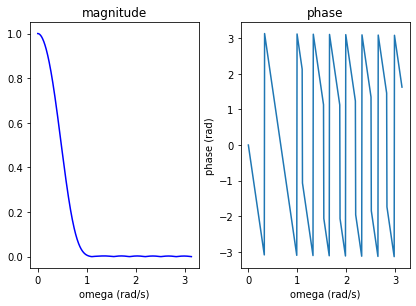

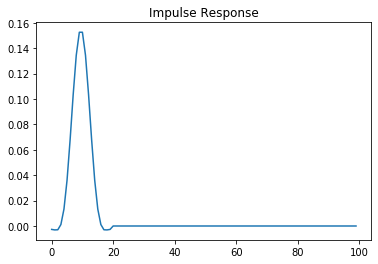

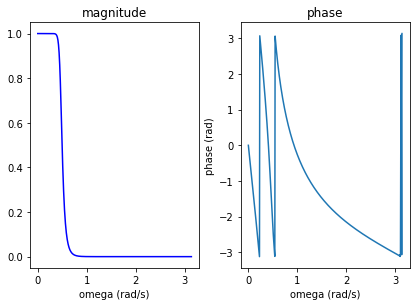

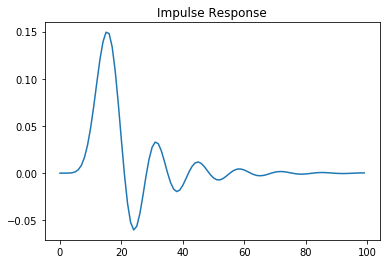

In [46]:
# Assignment 1 - Different Filter Implementations

# Part A
def plot_mag_freq_response(b, a, plot_phase = False, fs = None):
    # First generate H(omega) as described above in Briefing section (or use functions)
    
    # plot_phase and fs are 0 by default, feel free to change the default values
    # If plot_phase is 0, do not plot the phase response, else plot the phase response
    # If fs is 0, the x axis would be in radians, otherwise it would be in Hz based on the sampling frequency provided
    # Use signal.freqz to get your frequency response 

    w, h = sig.freqz(b, a, fs=fs) if fs else sig.freqz(b, a)

    fig, axs = plt.subplots(1, 1 + int(plot_phase))
    fig.tight_layout()
    
    axs[0].plot(w, abs(h), 'b')
    axs[0].set_title('magnitude')
    axs[0].set_xlabel(f'omega ({"Hz" if fs else "rad/s"})')
    axs[1].set_ylabel('amplitude')
    if(plot_phase):
        axs[1].plot(w, np.unwrap(np.angle(h)))
        axs[1].set_title('phase')
        axs[1].set_xlabel(f'omega ({"Hz" if fs else "rad/s"})')
        axs[1].set_ylabel('phase (rad)')

    return

# Part B

def plot_impulse_response(b, a, impulse_length):
    # Step 1: Use signal.lfilter to generate a filter
    x = np.zeros(impulse_length)
    x[0] = 1
    ht = sig.lfilter(b, a, x)

    # Step 2: Plot impulse response
    plt.figure()
    plt.title('Impulse Response')
    plt.plot(ht)

    # Step 3: return H(omega)
    w, h = sig.freqz(b, a)
    return w, h


# Part C
# Use signal.firwin and signal.butter to generate your b and a coefficients, then plot using the two functions above

fir_b = sig.firwin(20, 0.15)
fir_a = 1
plot_mag_freq_response(fir_b, fir_a, plot_phase=True)
w, h = plot_impulse_response(fir_b, fir_a, 100)

iir_b, iir_a = sig.butter(10, 0.15, 'low')

plot_mag_freq_response(iir_b, iir_a, plot_phase=True)
w, h = plot_impulse_response(iir_b, iir_a, 100)


###  Discussion

 Comment on the differences between the two filters in terms of the magnitude, phase and impulse responses.  What are the tradeoffs associated with these differences? 

 The butterworth filter is closer to an ideal filter than the firwin filter. The magnitude cutoff for the butterworth filter is sharper than the firwin filter. The phases have similar shape but the butterworth filter is smoother and the firwin filter. Some tradeoffs associated with these differences is that having such a sharp cutoff could negatively effect your output signal.

## Assignment 2 -- Different Filter Implementations for Smoothing Signals 

In lab 2B, you experimented with smoothing a noisy signal using a moving average window and a convolution. The convolution used an impulse response h[n] that was a causal version of the moving average window. In this problem, you will implement the smoothing function using the both convolution and the signal.lfilter command, to see that they give the same result. This assignment will have three parts, A-C.


**A.**  Using the code from lab 2, create a base time signal and a noisy version of it by adding random noise generated with the numpy.random.randn() function (the standard normal distribution, which is zero mean and unit variance). Plot the original and noisy signals together with the original overlaid on the noisy version, with the time axis labeled assuming a sampling rate of 1000 Hz. Constrain the y-axis to be [0,25] for all plots. Include a legend with the plot.

**B.**  Create one smoothed version of the signal called filtsig1 by using the convolve function from lab 2B with the box impulse response and k=10. Create a second version called filtsig2 by using the signal.lfilter function. Recall that for the FIR filter, the impulse response is equal to the b coefficient vector. Plot the two filtered signals overlaid. Recall that the convolve function will change the length, so you will need to define a new time vector for that. You should find that the two methods give the same result except for edge effects.

**C.**  Use the function that you wrote in assignment 1 to plot the magnitude and phase for the frequency response of this filter. It should look like a low pass filter.


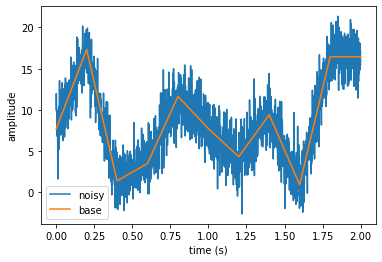

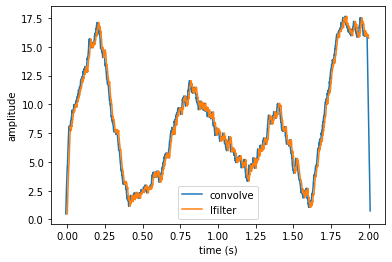

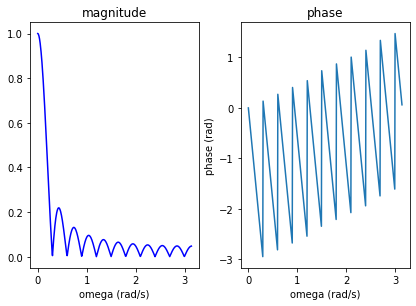

In [47]:
# Assignment 2 - Different Filter Implementations for Smoothing Signals
# set up relevant parameters
srate = 1000 # sampling rate in Hz
time  = np.arange(0,2,1/srate) # associated time vector that corresponds to 2 seconds
n     = len(time) # length of the time vector

# here is a base signal to work with, values of signal points chosen randomly
p     = 10 # points for piecewise linear signal
amp = 20   # amplitude range of base signal
base = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*amp)

# create some random noise to be added to the abve base signals
noiseamp = 2
noise  = noiseamp * np.random.randn(n)

# Part A
# Create a noisy signal and overlapping plot with base and noisy signal (use a legend to differentiate signals)
noisy = base + noise

fig, ax = plt.subplots()
ax.plot(time, noisy, label='noisy')
ax.plot(time, base, label='base')
ax.set_xlabel('time (s)')
ax.set_ylabel('amplitude')
ax.legend()


# Part B
# Use convolution from lab 2B and signal.lfilter to apply your filter

k=10

def smooth_convolve(a, k):
    hfilt = np.ones(2*k + 1) / (2*k + 1)
    y = np.convolve(a, hfilt)
    t = np.arange(-k, len(y) - k)/srate
    return t, y

filtsig1_t, filtsig1 = smooth_convolve(noisy, k)

fir_b = np.ones(2*k + 1) / (2*k + 1)
fir_a = 1
filtsig2 = sig.lfilter(fir_b, fir_a, noisy)

fig, ax = plt.subplots()
ax.plot(filtsig1_t, filtsig1, label='convolve')
ax.plot(time, filtsig2, label='lfilter')
ax.set_xlabel('time (s)')
ax.set_ylabel('amplitude')
ax.legend()

# Part C
# Use function to plot magnitude and phase
plot_mag_freq_response(fir_b, fir_a, plot_phase=True)

###  Discussion

The moving window average (and its causal version) is an FIR filter, so the phase should be linear. How might the result change if you used a Butterworth filter?